Ships and Bikes model:

In [2]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import PIL.Image
import urllib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from tensorboard.plugins.hparams import api as hp

2.2.0-rc3


In [3]:
ships_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04194289")#ship synset
print(ships_page.content)
# BeautifulSoup is an HTML parsing library
ships_soup = BeautifulSoup(ships_page.content, 'html.parser')#puts the content of the website into the soup variable, each url on a different line

bikes_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02834778")#bicycle synset
print(bikes_page.content)
# BeautifulSoup is an HTML parsing library
from bs4 import BeautifulSoup
bikes_soup = BeautifulSoup(bikes_page.content, 'html.parser')#puts the content of the website into the soup variable, each url on a different line

b"http://static.flickr.com/85/233578996_8f74463083.jpg\r\nhttp://farm3.static.flickr.com/2317/2472759369_f4cc1ff8a0.jpg\r\nhttp://static.flickr.com/2173/2071797511_200e3e4d2e.jpg\r\nhttp://farm2.static.flickr.com/1019/534041866_3aa182311c.jpg\r\nhttp://static.flickr.com/88/231940102_7beb5ecf3e.jpg\r\nhttp://farm4.static.flickr.com/3138/2724596903_d74dd64821.jpg\r\nhttp://static.flickr.com/174/453920264_9406e9972c.jpg\r\nhttp://farm2.static.flickr.com/1419/1408865234_caf87d02e3.jpg\r\nhttp://farm1.static.flickr.com/147/423542865_c091691a6b.jpg\r\nhttp://farm3.static.flickr.com/2074/2367492616_272bf6af6a.jpg\r\nhttp://farm2.static.flickr.com/1081/1365111200_8d105d9fb1.jpg\r\nhttp://farm3.static.flickr.com/2269/2348294071_94fc609f4a.jpg\r\nhttp://static.flickr.com/1016/1443997081_b5eb875055.jpg\r\nhttp://www.walleniuslines.com/img_upload/maersk_teal.jpg\r\nhttp://www.fondear.org/infonautic/Barco/Barco_Navegando/Contenedores_Peligro/sea_container_ship2.jpg\r\nhttp://static.flickr.com/198/4

Import ResNet Arch


In [4]:
str_ships_soup=str(ships_soup)#convert soup to string so it can be split
type(str_ships_soup)
ships_split_urls=str_ships_soup.split('\r\n')#split so each url is a different possition on a list
print("The length of the ships list is ",len(ships_split_urls))#print the length of the list so you know how many urls you have

bikes_str_soup=str(bikes_soup)#convert soup to string so it can be split
type(bikes_str_soup)
bikes_split_urls=bikes_str_soup.split('\r\n')#split so each url is a different possition on a list
print("The length of the bikes list is ", len(bikes_split_urls))

The length of the ships list is  1262
The length of the bikes list is  1345


Make training and validation directories

Correct the images shape, format, and store them on the corresponding directory

In [15]:
img_rows, img_cols = 2224, 2224 
input_shape = (img_rows, img_cols, 3)




TRAIN:


list the files inside ships directory:

img0.jpg    img260.jpg	img391.jpg  img550.jpg	img69.jpg   img839.jpg
img102.jpg  img262.jpg	img394.jpg  img551.jpg	img690.jpg  img841.jpg
img103.jpg  img264.jpg	img395.jpg  img552.jpg	img691.jpg  img842.jpg
img105.jpg  img265.jpg	img396.jpg  img554.jpg	img692.jpg  img843.jpg
img107.jpg  img267.jpg	img399.jpg  img556.jpg	img693.jpg  img844.jpg
img108.jpg  img268.jpg	img4.jpg    img557.jpg	img694.jpg  img845.jpg
img11.jpg   img270.jpg	img40.jpg   img558.jpg	img697.jpg  img849.jpg
img111.jpg  img271.jpg	img400.jpg  img56.jpg	img698.jpg  img851.jpg
img113.jpg  img272.jpg	img401.jpg  img560.jpg	img699.jpg  img852.jpg
img115.jpg  img273.jpg	img404.jpg  img562.jpg	img700.jpg  img853.jpg
img116.jpg  img274.jpg	img407.jpg  img563.jpg	img701.jpg  img855.jpg
img117.jpg  img276.jpg	img408.jpg  img564.jpg	img702.jpg  img856.jpg
img118.jpg  img277.jpg	img409.jpg  img565.jpg	img704.jpg  img857.jpg
img12.jpg   img279.jpg	img410.jpg  img566.jpg	img708.j

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=50,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
                                   
validation_datagen = ImageDataGenerator(rescale=1/255)


Building the model: Resnet with one Block


In [101]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.0 MB 9.1 MB/s eta 0:00:01


In [173]:
import tensorflow_addons as tfa

inputs = tf.keras.Input(shape=(224, 224, 3), name='img')
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
block_1_output = tf.keras.layers.MaxPooling2D(3)(x)

# Psuedo Inception
a = tf.keras.layers.Conv2D(32, 1, activation='relu', padding='same')(block_1_output)
b = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_1_output)
c = tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same')(block_1_output)
d = tf.keras.layers.MaxPool2D(3, strides=1, padding='same')(block_1_output)
block_2_output = tf.keras.layers.concatenate([a,b,c,d])

x = tf.keras.layers.Conv2D(32, 1, activation='relu', padding='same')(block_2_output)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, 1, activation='relu', padding='same')(x)
block_3_output = tf.keras.layers.add([x, block_1_output]) # Must link to 1 since inception is different size

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_3_output)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
block_4_output = tf.keras.layers.add([x, block_3_output]) # Standard ResNet

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_4_output)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
block_5_output = tf.keras.layers.add([x, block_4_output]) # Standard ResNet

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_5_output)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
block_6_output = tf.keras.layers.add([x, block_5_output]) # Standard ResNet

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_6_output)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
block_7_output = tf.keras.layers.add([x, block_6_output]) # Standard ResNet

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(block_7_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name='mini_resnet')
model.summary()




Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_814 (Conv2D)             (None, 224, 224, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_815 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_814[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_111 (MaxPooling2D (None, 74, 74, 32)   0           conv2d_815[0][0]                 
________________________________________________________________________________________

In [177]:


model.compile(loss='binary_crossentropy',
              optimizer=tfa.optimizers.LazyAdam(0.0001),
             metrics=['acc'])
train_generator = train_datagen.flow_from_directory(
        '/data/content/train/',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/data/content/validation/',  
        target_size=(224, 224),  
        batch_size=20,
        class_mode='binary')
model.fit_generator(
    train_generator,
    steps_per_epoch=40,
    epochs=12,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=10
  )

# This was giving me 0.8 to 0.9 running over 25+ Epochs with good validation 0.87+.  Looks like we are limited by number of 
# unique samples.


Found 1270 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Epoch 1/12
40/40 [==============================] - 9s 223ms/step - loss: 0.4363 - acc: 0.8087 - val_loss: 0.3941 - val_acc: 0.8350
Epoch 2/12
40/40 [==============================] - 9s 214ms/step - loss: 0.3097 - acc: 0.8684 - val_loss: 0.2323 - val_acc: 0.9096
Epoch 3/12
40/40 [==============================] - 9s 217ms/step - loss: 0.3684 - acc: 0.8512 - val_loss: 0.3507 - val_acc: 0.8550
Epoch 4/12
40/40 [==============================] - 9s 217ms/step - loss: 0.3454 - acc: 0.8494 - val_loss: 0.2966 - val_acc: 0.8723
Epoch 5/12
40/40 [==============================] - 9s 216ms/step - loss: 0.3723 - acc: 0.8380 - val_loss: 0.3033 - val_acc: 0.8457
Epoch 6/12
40/40 [==============================] - 9s 214ms/step - loss: 0.3730 - acc: 0.8375 - val_loss: 0.4010 - val_acc: 0.8150
Epoch 7/12
40/40 [==============================] - 9s 215ms/step - loss: 0.3724 - acc: 0.8506 - val_loss: 0.3057 - val_acc: 

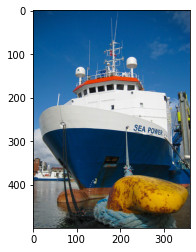

In [160]:
plt.imshow(PIL.Image.open("/data/content/validation/ships/img11.jpg"))

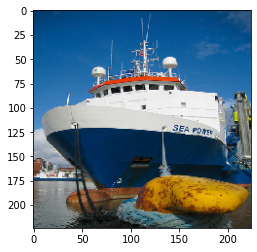

In [161]:
from tensorflow.keras.preprocessing import image

img_path='/data/content/validation/ships/img11.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

In [162]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd5e145fc50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e145fbe0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd600349198>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd5e1463320>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e146d5c0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e1473400>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e147b6a0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd5e14025c0>, <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fd5e1402438>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e1409550>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e1409be0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5e140fdd8>, <tensorflow.python.keras.layers.merge.Ad

In [163]:
layer_outputs = [layer.output for layer in model.layers[:13]]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

224
(0, 2240)
224
(672, 2240)
224
(672, 2240)
74
(222, 740)
74
(222, 740)
74
(222, 740)
74
(222, 740)
74
(222, 740)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


74
(888, 740)
74
(222, 740)
74
(222, 740)
74
(222, 740)


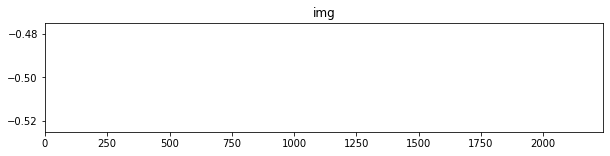

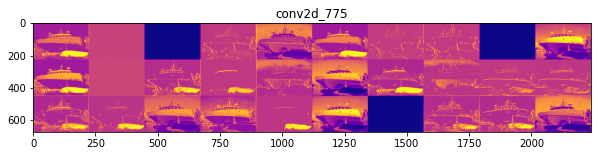

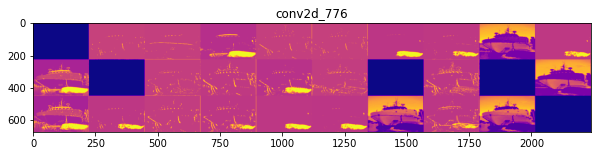

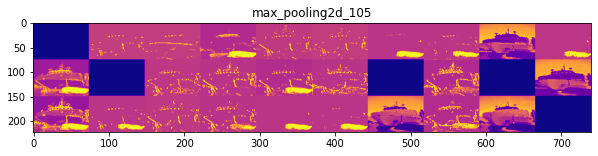

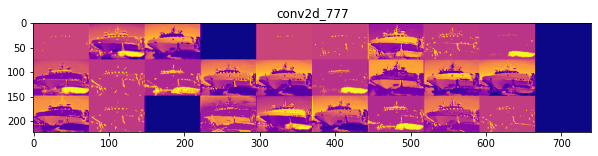

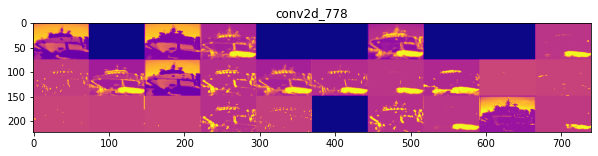

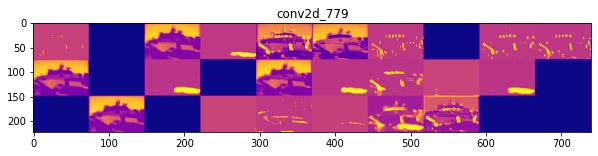

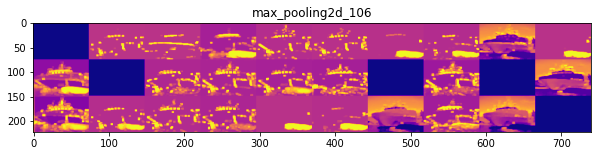

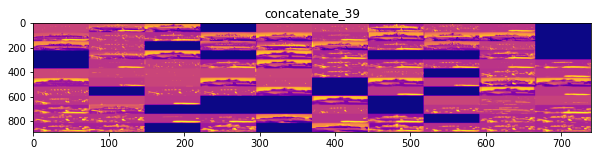

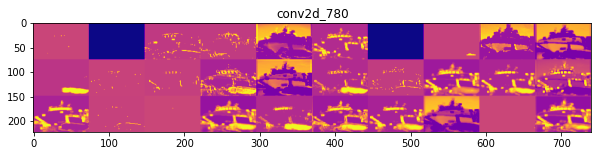

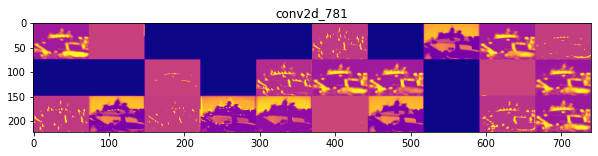

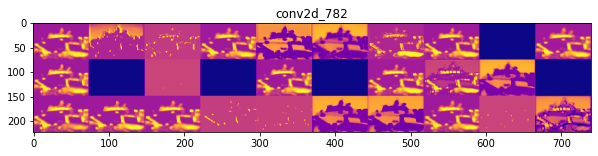

In [165]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)
    
images_per_row = 10

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] 
    
    size = layer_activation.shape[1] 
    print(size)
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): 
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() 
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    print(display_grid.shape)
    
    plt.figure(figsize=(10,2))
               
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')